In [1]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [2]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import os

Using TensorFlow backend.


In [0]:
from matplotlib import pyplot as plt
import math
from keras.callbacks import LambdaCallback
from keras.callbacks import Callback
import keras.backend as K
import numpy as np
import os

In [0]:
tf.enable_eager_execution()

In [0]:
BATCH_SIZE =  128#@param {type:"integer"}
MOMENTUM = 0.9 #@param {type:"number"}
LEARNING_RATE =  2e-5#@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS =  100#@param {type:"integer"}

In [0]:
# Define a function for pytorch style weight initialization

def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

# Resenet 18 on cifar 10

Taken help of the following blog post:

https://towardsdatascience.com/deep-convolutional-neural-networks-ccf96f830178?

http://www.pabloruizruiz10.com/resources/CNNs/ResNet-on-CIFAR10.pdf


## First Convolution Block

*   Normal ResNet model uses image size of 224*224 as the input and a convolution block and maxpooling are used to bring input image size quickly to 56x56.
*   But in our case we are dealing with cifar10 which as a input size of 32*32. 
Hence we are not using MaxPooling and we have made passing same such that the image size is carried forwarded to next blocks


## ResNet Block


*   Similar have retained the original architecture of ResNet18 except channels and stride.
*   We are not using stride at each layer, we have used it on 2nd and 4th ResNet block. 


##Final Block

*   Finally We are using GlobalMaxPooling on the final layer and get an output of 8*8 image size
*   At the end we are using dense layer to connect 8*8 size 


 








In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out, stride = 1):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3,strides=stride,padding="SAME",kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.85, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
# Define a ResNet block
class ResNetBlk(tf.keras.Model):
  def __init__(self,channel_input,channel_output,stride = 1):
    #By default stide is set to 1
    super().__init__()
    self.stride = stride
    self.channel_input = channel_input
    self.channel_output = channel_output
    self.momentum_value_1 = 0.85
    self.momentum_value_2 = 0.85
    #Define all the layers in the block
    self.conv_layer_1 = tf.keras.layers.Conv2D(filters=channel_output, kernel_size=3,strides=stride,padding="SAME", kernel_initializer=init_pytorch,use_bias=False)
    self.batch_normalize_1 = tf.keras.layers.BatchNormalization(momentum=self.momentum_value_1, epsilon=1e-5)
    self.conv_layer_2 = tf.keras.layers.Conv2D(filters=channel_output, kernel_size=3,strides=1,padding="SAME", kernel_initializer=init_pytorch,use_bias=False)
    self.batch_normalize_2 = tf.keras.layers.BatchNormalization(momentum=self.momentum_value_1, epsilon=1e-5)
    self.conv3 = tf.keras.layers.Conv2D(filters=channel_output, kernel_size=3,strides=1,padding="SAME", kernel_initializer=init_pytorch,use_bias=False)
    self.bn3 = tf.keras.layers.BatchNormalization(momentum=self.momentum_value_1, epsilon=1e-5)
    self.conv4 = tf.keras.layers.Conv2D(filters=channel_output, kernel_size=3,strides=1,padding="SAME", kernel_initializer=init_pytorch,use_bias=False)
    self.bn4 = tf.keras.layers.BatchNormalization(momentum=self.momentum_value_1, epsilon=1e-5)
    self.residual_concat = tf.keras.layers.Conv2D(filters=channel_output, kernel_size=1,strides=stride,padding="SAME",kernel_initializer=init_pytorch,use_bias=False)


  def call(self, inputs):

    layer_activation_1 = self.batch_normalize_2(self.conv_layer_2(tf.nn.relu(self.batch_normalize_1(self.conv_layer_1(inputs)))))
    # Modify the size wrt to the stride size
    if self.stride != 1 or self.channel_input != self.channel_output:
      layer_activation_1 = self.residual_concat(inputs) + layer_activation_1
    else:
      layer_activation_1 = inputs + layer_activation_1
      
    layer_activation_2 = tf.nn.relu(self.bn3(self.conv3(tf.nn.relu(layer_activation_1))))
    layer_activation_2 = self.bn4(self.conv4(layer_activation_2))
    final_layer_activation = layer_activation_1 + layer_activation_2      
    final_layer_activation = tf.nn.relu(final_layer_activation)  
    return final_layer_activation

In [0]:
class ResNet18(tf.keras.Model):
  def __init__(self,c=64):
    super().__init__()    
    self.starting_conv_bn = ConvBN(c,stride = 1)    # output size: 32x32x64
    self.blk1 = ResNetBlk(c,c,stride = 1)        # output size: 32x32x64
    self.blk2 = ResNetBlk(c,c*2,stride = 2)      # output size: 16x16x128
    self.blk3 = ResNetBlk(c*2,c*4,stride = 1)    # output size: 16x16x256
    self.blk4 = ResNetBlk(c*4,c*8,stride = 2)    # output size:  8x 8x512
    
    #We have used Global Average Pooling layer followed by FC to get 10 o/p values
    self.pool_layer = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)    

  def call(self, x, y):
    h = self.blk4(self.blk3(self.blk2(self.blk1(self.starting_conv_bn(x)))))    
    h = self.linear(self.pool_layer(h))    
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [10]:
# Download CIFAR10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)

y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# Standard mean and Standard devaiation for dataset
# 3 means and 3 std devaiation for 3 channels(RGB)
train_mean = np.array([0.4914, 0.4822, 0.4465])
train_std = np.array([0.2023, 0.1994, 0.2010])

normalize = lambda x: ((x - train_mean) / train_std).astype('float32')

#Random Crop of 32 with padding of 4px
layer_pading = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(layer_pading(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 6s 0us/step


In [0]:
#Data augementation Random crop, followed by random flip 
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3])), y)

In [0]:
# LR_finder class
class LR_Finder():    
    def __init__(self, model):
        self.model = model
        self.best_loss = 1e9
        self.avg_loss = 0
        self.losses, self.smoothed_losses, self.lrs, self.iterations = [], [], [], []
        self.iteration = 0
        self.start_lr = 1e-8
        self.end_lr = 1
        self.beta = 0.98
   

    def custom_lr_with_loss(self,x_train,y_train,batch_size=128,step_size=None):
        self.step_size = step_size
        self.lr_mult = (self.end_lr/self.start_lr)**(1/step_size)     

        lr_finder_func = lambda: self.start_lr * (self.lr_mult ** (self.iteration)) 
        opt_value = tf.train.MomentumOptimizer(lr_finder_func, momentum=MOMENTUM, use_nesterov=True)        
        train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(batch_size)
        tf.keras.backend.set_learning_phase(1)
        for (x, y) in tqdm(train_set):
          lr = lr_finder_func()          
          with tf.GradientTape() as tape:
            loss, correct = model(x, y)
          var = model.trainable_variables
          grads = tape.gradient(loss, var)
          for g, v in zip(grads, var):
            g += v * WEIGHT_DECAY * BATCH_SIZE
          opt_value.apply_gradients(zip(grads, var))
          loss, correct = model(x, y)
          loss = (loss/batch_size)  
          self.avg_loss = self.beta * self.avg_loss + (1 - self.beta) * loss
          smoothed_loss = self.avg_loss / (1 - self.beta**self.iteration)          
          self.losses.append(loss)
          self.smoothed_losses.append(smoothed_loss)
          self.lrs.append(lr)
          self.iterations.append(self.iteration)  
          # If loss exploding
          if self.iteration>1 and smoothed_loss > self.best_loss * 4:
              self.model.stop_training = True
              print('loss is exploding')
              break
          if smoothed_loss < self.best_loss or self.iteration==1:
              self.best_loss = smoothed_loss
          self.iteration += 1
        
    def plot_lr(self):
        plt.xlabel('Iterations')
        plt.ylabel('Learning rate')
        plt.plot(self.iterations, self.lrs)
        
    def plot(self, n_skip=10):
        plt.ylabel('Loss')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_smoothed_loss(self, n_skip=10):
        plt.ylabel('Smoothed Losses')
        plt.xlabel('Learning rate (log scale)')
        plt.plot(self.lrs[n_skip:-5], self.smoothed_losses[n_skip:-5])
        plt.xscale('log')
        
    def plot_loss(self):
        plt.ylabel('Losses')
        plt.xlabel('Iterations')
        plt.plot(self.iterations[10:], self.losses[10:])

In [0]:
model = ResNet18()

In [14]:
lr_finder = LR_Finder(model)
#lr_finder.find(x_train, y_train, start_lr=1e-8, end_lr=1, batch_size=BATCH_SIZE,step_size=np.ceil(len_train/BATCH_SIZE), beta=0.98)
lr_finder.custom_lr_with_loss(x_train, y_train, batch_size=BATCH_SIZE,step_size=np.ceil(len_train/BATCH_SIZE))

loss is exploding


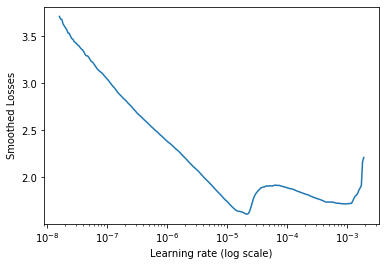

In [15]:
lr_finder.plot_smoothed_loss()

## Model Training

In [0]:
model = ResNet18()
batches_per_epoch = len_train//BATCH_SIZE + 1
global_step = tf.train.get_or_create_global_step()
opt = tf.train.MomentumOptimizer(LEARNING_RATE, momentum=MOMENTUM,use_nesterov=True)
data_aug = lambda x, y: (tf.image.random_flip_left_right(tf.random_crop(x,[32, 32, 3])),y)

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
top_acc = 0.0
training_loss = []
testing_loss = []

t = time.time()
test_set = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)


train_accuracy = []
test_accuracy = []

for epoch in range(EPOCHS):
  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = tf.data.Dataset.from_tensor_slices((x_train, y_train)).map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()

  model_final_weights_path = '/content/drive/My Drive/connecting dots/assignment_13_final_best_weights.h5'
  model_last_best_path = '/content/drive/My Drive/connecting dots/assignment_13_last_best_weights.h5'

  current_test_accuracy = (test_acc/len_test) 
  current_train_accuracy = (train_acc/len_train) 
  test_accuracy.append(current_test_accuracy)  
  train_accuracy.append(current_train_accuracy)


  testing_loss.append(test_loss / len_test)
  training_loss.append(train_loss / len_train)

# If accuracy has improved save the model weights.
  if(current_test_accuracy > top_acc):
    print('Accuracy improved from {} to {}.'.format(top_acc,current_test_accuracy,model_last_best_path))
    top_acc = current_test_accuracy
    model.save_weights(model_last_best_path)

# If test accuracy is more than 92%
  if(current_test_accuracy >= 0.92):
    print('Test accuracy is more than 92%.') 
    model.save_weights(model_final_weights_path)
    break     

  print('epoch:', epoch+1, 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)

Accuracy improved from 0.0 to 0.6639.
epoch: 1 train loss: 1.033462963104248 train acc: 0.63132 val loss: 0.9860707649230958 val acc: 0.6639 time: 144.18311738967896


Accuracy improved from 0.6639 to 0.7299.
epoch: 2 train loss: 0.8042597032165527 train acc: 0.71992 val loss: 0.7665677764892578 val acc: 0.7299 time: 290.7439260482788


Accuracy improved from 0.7299 to 0.7871.
epoch: 3 train loss: 0.6583214862823487 train acc: 0.77174 val loss: 0.6207011904716492 val acc: 0.7871 time: 437.4449825286865


Accuracy improved from 0.7871 to 0.7958.
epoch: 4 train loss: 0.5543404727172851 train acc: 0.80894 val loss: 0.5895285026550293 val acc: 0.7958 time: 583.3236932754517


Accuracy improved from 0.7958 to 0.8227.
epoch: 5 train loss: 0.48190074935913085 train acc: 0.83148 val loss: 0.5344859568595887 val acc: 0.8227 time: 729.8500845432281


Accuracy improved from 0.8227 to 0.8427.
epoch: 6 train loss: 0.42923158241271975 train acc: 0.85244 val loss: 0.4555311622619629 val acc: 0.8427 time: 875.7600209712982


epoch: 7 train loss: 0.38103641632080076 train acc: 0.86824 val loss: 0.5134091296672821 val acc: 0.8303 time: 1021.2841079235077


Accuracy improved from 0.8427 to 0.8521.
epoch: 8 train loss: 0.342852571144104 train acc: 0.88106 val loss: 0.4465500147819519 val acc: 0.8521 time: 1167.5863847732544


Accuracy improved from 0.8521 to 0.8689.
epoch: 9 train loss: 0.3045614079284668 train acc: 0.89294 val loss: 0.3943296781539917 val acc: 0.8689 time: 1314.7155168056488


epoch: 10 train loss: 0.27572479539871214 train acc: 0.9039 val loss: 0.4280048097610474 val acc: 0.8602 time: 1460.4613313674927


Accuracy improved from 0.8689 to 0.876.
epoch: 11 train loss: 0.25556533409118654 train acc: 0.91 val loss: 0.3874249430656433 val acc: 0.876 time: 1606.612030506134


epoch: 12 train loss: 0.22877250194549562 train acc: 0.91966 val loss: 0.41389471945762635 val acc: 0.8691 time: 1751.832491159439


epoch: 13 train loss: 0.20096362369537354 train acc: 0.93006 val loss: 0.404719083404541 val acc: 0.8753 time: 1897.2829995155334


Accuracy improved from 0.876 to 0.8773.
epoch: 14 train loss: 0.187093410987854 train acc: 0.93378 val loss: 0.3835919917106628 val acc: 0.8773 time: 2043.0371930599213


Accuracy improved from 0.8773 to 0.8847.
epoch: 15 train loss: 0.17127915155410767 train acc: 0.93976 val loss: 0.3701728554725647 val acc: 0.8847 time: 2189.383247613907


Accuracy improved from 0.8847 to 0.8865.
epoch: 16 train loss: 0.1525329025745392 train acc: 0.94706 val loss: 0.37275463914871215 val acc: 0.8865 time: 2335.506406545639


Accuracy improved from 0.8865 to 0.8917.
epoch: 17 train loss: 0.1349527936935425 train acc: 0.95244 val loss: 0.3542036885261536 val acc: 0.8917 time: 2481.916118621826


Accuracy improved from 0.8917 to 0.8957.
epoch: 18 train loss: 0.12142758080482483 train acc: 0.9573 val loss: 0.3454646231651306 val acc: 0.8957 time: 2627.786319255829


Accuracy improved from 0.8957 to 0.8997.
epoch: 19 train loss: 0.11450589024543763 train acc: 0.9602 val loss: 0.34021203632354735 val acc: 0.8997 time: 2773.440802335739


epoch: 20 train loss: 0.10397481884002685 train acc: 0.9645 val loss: 0.36868725023269655 val acc: 0.8933 time: 2918.509511947632


epoch: 21 train loss: 0.09190599337100983 train acc: 0.96818 val loss: 0.3713611019134522 val acc: 0.8955 time: 3063.42498087883


epoch: 22 train loss: 0.08754979252815247 train acc: 0.97004 val loss: 0.3626800965309143 val acc: 0.8972 time: 3208.7965762615204


Accuracy improved from 0.8997 to 0.9005.
epoch: 23 train loss: 0.0789685675573349 train acc: 0.97186 val loss: 0.3527364691734314 val acc: 0.9005 time: 3354.8037984371185


epoch: 24 train loss: 0.07226873052597046 train acc: 0.97512 val loss: 0.36288514404296873 val acc: 0.8963 time: 3500.834086418152


epoch: 25 train loss: 0.06603544260263443 train acc: 0.97786 val loss: 0.4079201135635376 val acc: 0.8918 time: 3646.059480190277


Accuracy improved from 0.9005 to 0.9053.
epoch: 26 train loss: 0.06204739774942398 train acc: 0.97884 val loss: 0.35740318574905394 val acc: 0.9053 time: 3792.4487109184265


epoch: 27 train loss: 0.05633845213413238 train acc: 0.98114 val loss: 0.36146329126358034 val acc: 0.9014 time: 3937.4840734004974


epoch: 28 train loss: 0.0507587621486187 train acc: 0.9822 val loss: 0.4069011451721191 val acc: 0.8946 time: 4082.924402952194


epoch: 29 train loss: 0.04381868263244629 train acc: 0.9854 val loss: 0.3823954436302185 val acc: 0.9011 time: 4227.6654920578


epoch: 30 train loss: 0.04092769678115845 train acc: 0.98648 val loss: 0.35876724252700803 val acc: 0.9045 time: 4372.651048183441


Accuracy improved from 0.9053 to 0.9084.
epoch: 31 train loss: 0.04022262210607529 train acc: 0.98616 val loss: 0.35426884565353395 val acc: 0.9084 time: 4518.765875339508


epoch: 32 train loss: 0.035356944082975385 train acc: 0.98802 val loss: 0.3862015091896057 val acc: 0.902 time: 4663.8740355968475


epoch: 33 train loss: 0.037138335213661194 train acc: 0.9876 val loss: 0.3611034553766251 val acc: 0.9072 time: 4808.881833076477


Accuracy improved from 0.9084 to 0.9089.
epoch: 34 train loss: 0.0328829401499033 train acc: 0.98944 val loss: 0.36595054302215574 val acc: 0.9089 time: 4955.014456510544


Accuracy improved from 0.9089 to 0.912.
epoch: 35 train loss: 0.026659187443852424 train acc: 0.99156 val loss: 0.37147361211776736 val acc: 0.912 time: 5101.327456235886


epoch: 36 train loss: 0.02750933106780052 train acc: 0.9912 val loss: 0.37191826696395874 val acc: 0.9109 time: 5246.6980509758


Accuracy improved from 0.912 to 0.9125.
epoch: 37 train loss: 0.028980665875673293 train acc: 0.99002 val loss: 0.3617643937110901 val acc: 0.9125 time: 5393.027041435242


epoch: 38 train loss: 0.024691490701436995 train acc: 0.992 val loss: 0.39783237838745117 val acc: 0.9034 time: 5538.163422584534


epoch: 39 train loss: 0.02467329222202301 train acc: 0.99154 val loss: 0.36339984035491946 val acc: 0.9111 time: 5683.599331617355


epoch: 40 train loss: 0.02516860885709524 train acc: 0.99182 val loss: 0.36931642990112307 val acc: 0.9094 time: 5828.5319612026215


epoch: 41 train loss: 0.01945486676990986 train acc: 0.99402 val loss: 0.3590321687698364 val acc: 0.9112 time: 5973.690627336502


epoch: 42 train loss: 0.020060023232996462 train acc: 0.99324 val loss: 0.3814685959815979 val acc: 0.9091 time: 6119.045624017715


epoch: 43 train loss: 0.020476361151635647 train acc: 0.99356 val loss: 0.38125220890045164 val acc: 0.9101 time: 6264.500271320343


epoch: 44 train loss: 0.016446966502666475 train acc: 0.99498 val loss: 0.36541281661987307 val acc: 0.9121 time: 6409.792603969574


Accuracy improved from 0.9125 to 0.9188.
epoch: 45 train loss: 0.015481507397294045 train acc: 0.99524 val loss: 0.35201277494430544 val acc: 0.9188 time: 6556.397623538971


epoch: 46 train loss: 0.012926580922603606 train acc: 0.99642 val loss: 0.36191610193252566 val acc: 0.9131 time: 6701.609247207642


epoch: 47 train loss: 0.014505971945226192 train acc: 0.9955 val loss: 0.3902718656539917 val acc: 0.9113 time: 6846.802780628204


epoch: 48 train loss: 0.01530640083462 train acc: 0.9953 val loss: 0.3767310878753662 val acc: 0.9108 time: 6991.925180912018


epoch: 49 train loss: 0.01474861197784543 train acc: 0.9955 val loss: 0.37697396783828735 val acc: 0.9123 time: 7137.06701874733


epoch: 50 train loss: 0.01355807686150074 train acc: 0.99584 val loss: 0.3890563491821289 val acc: 0.9108 time: 7282.15710568428


epoch: 51 train loss: 0.011460092554986477 train acc: 0.99644 val loss: 0.3695873097419739 val acc: 0.9157 time: 7427.31804728508


epoch: 52 train loss: 0.01006885533876717 train acc: 0.99706 val loss: 0.42671374130249023 val acc: 0.9051 time: 7572.752576589584


epoch: 53 train loss: 0.009019954204335809 train acc: 0.9974 val loss: 0.3833632248878479 val acc: 0.9155 time: 7718.444005250931


epoch: 54 train loss: 0.01056268248423934 train acc: 0.99708 val loss: 0.38565140886306765 val acc: 0.912 time: 7863.868829727173


epoch: 55 train loss: 0.009608288889825345 train acc: 0.9971 val loss: 0.3756777361869812 val acc: 0.9139 time: 8009.239862203598


epoch: 56 train loss: 0.011125231916755438 train acc: 0.99656 val loss: 0.3590934545516968 val acc: 0.9182 time: 8154.9768126010895


epoch: 57 train loss: 0.010029026922136546 train acc: 0.99694 val loss: 0.39061156673431396 val acc: 0.9156 time: 8300.166160106659


epoch: 58 train loss: 0.00871536697179079 train acc: 0.99756 val loss: 0.39157903299331664 val acc: 0.9155 time: 8445.510841608047


epoch: 59 train loss: 0.007973879767730832 train acc: 0.9977 val loss: 0.3820724175453186 val acc: 0.9167 time: 8590.464599370956


epoch: 60 train loss: 0.008721419324204326 train acc: 0.99754 val loss: 0.39429906978607177 val acc: 0.9148 time: 8735.971004486084


epoch: 61 train loss: 0.00758096785992384 train acc: 0.99772 val loss: 0.37586616287231445 val acc: 0.9175 time: 8881.217927455902


Accuracy improved from 0.9188 to 0.9189.
epoch: 62 train loss: 0.008261924153752626 train acc: 0.99762 val loss: 0.3730753168106079 val acc: 0.9189 time: 9027.31714439392


epoch: 63 train loss: 0.007110199482366443 train acc: 0.99794 val loss: 0.37876183376312256 val acc: 0.9157 time: 9172.204825878143


epoch: 64 train loss: 0.006429859730750323 train acc: 0.9983 val loss: 0.37177899074554444 val acc: 0.918 time: 9317.259433031082


epoch: 65 train loss: 0.005885856897085905 train acc: 0.99846 val loss: 0.39260507049560545 val acc: 0.9145 time: 9461.911463975906


epoch: 66 train loss: 0.004941224075704813 train acc: 0.99884 val loss: 0.38560575065612795 val acc: 0.9157 time: 9607.126542329788


epoch: 67 train loss: 0.005132333732806146 train acc: 0.99872 val loss: 0.39029152364730835 val acc: 0.9153 time: 9752.663794279099


Accuracy improved from 0.9189 to 0.9214.
Test accuracy is more than 92%.


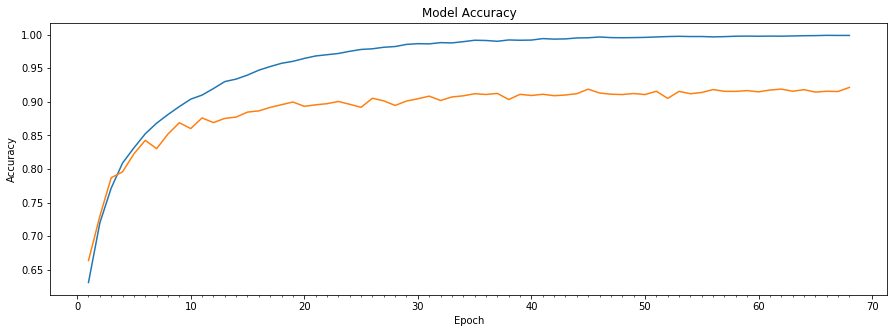

In [28]:
import matplotlib.pyplot as plt

fig_1,axs_1 = plt.subplots(1,1,figsize=(15,5))   # define a plot with 1 row and 2 columns of subplots
    
# summarize history for accuracy
axs_1.plot(range(1,len(train_accuracy)+1),train_accuracy)
axs_1.plot(range(1,len(test_accuracy)+1),test_accuracy)
axs_1.set_title('Model Accuracy')
axs_1.set_ylabel('Accuracy')
axs_1.set_xlabel('Epoch')
axs_1.set_xticks(np.arange(1,len(train_accuracy)+1),len(train_accuracy)/10)
plt.show()

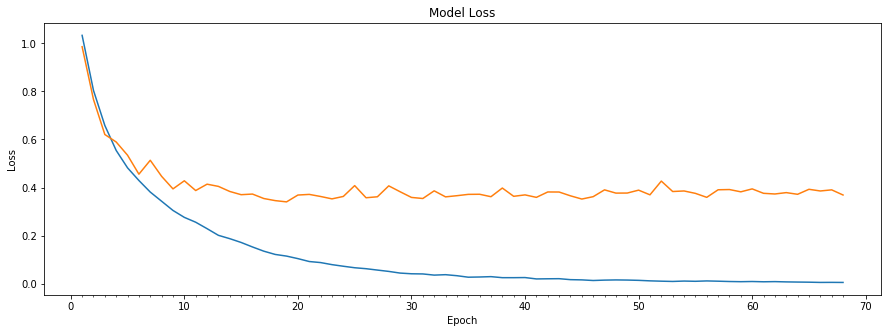

In [29]:
fig_2, axs_2 = plt.subplots(1,1,figsize=(15,5))   # define a plot with 1 row and 2 columns of subplots
    
# summarize history for loss
axs_2.plot(range(1,len(training_loss)+1),training_loss)
axs_2.plot(range(1,len(testing_loss)+1),testing_loss)
axs_2.set_title('Model Loss') 
axs_2.set_ylabel('Loss')
axs_2.set_xlabel('Epoch')
axs_2.set_xticks(np.arange(1,len(training_loss)+1),len(training_loss)/10)
plt.show()